This notebook walks through a few examples that show how to use `triceratops`. The examples below show:

1. How to apply `triceratops` on a star observed in a $\textbf{single}$ ${\it TESS}$ sector $\textbf{without}$ follow up data.
2. How to apply `triceratops` on a star observed in a $\textbf{single}$ ${\it TESS}$ sector $\textbf{with}$ follow up data.
3. How to apply `triceratops` on a star observed in $\textbf{multiple}$ ${\it TESS}$ sectors $\textbf{without}$ follow up data.

In [1]:
import numpy as np
import pandas as pd
import time
from lightkurve import TessLightCurve
import matplotlib.pyplot as plt
%matplotlib inline

import triceratops.triceratops as tr

## Example #1

First, let's apply the tool on TOI 465.01 (aka TIC 270380593.01, aka WASP-156b), which was observed with a 2 minute cadence in sector 4.

Begin by defining the target star object with the `target(ID, sectors)` class. The arguments for this class are `ID` (the TIC ID of the star) and `sectors` (the sectors in which the star was observed). `ID` should be an integer and `sectors` should be a numpy array.



In [2]:
ID = 470381900
sectors = np.array([19])
target = tr.target(ID=ID, sectors=sectors)

Next, let's define the aperture used to extract the light curve, plot an image of the field, and display a table of nearby stars.

The aperture should be a 2D numpy array with the formal `[[col#, row#], [col#, row#], [col#, row#], ...]`, where where each `[col#, row#]` is the column and row number of the pixel.

An image of the field can be plotted with the `.plot_field(sector, ap_pixels)` method. This method takes as optional arguments `sector` (the image sector you would like to plot) and `ap_pixels` (the aperture we just defined).

We can display a table of the stars in the image with the `.stars` attribute. This table contains the separation and position angle of each star from the target star, so that each can be identified in the plot. Note that the scale of a TESS pixel is about 20 arcseconds.

In [9]:
import lightkurve as lk

res = lk.search_targetpixelfile(f"TIC {ID}")
tpf = res[0].download()

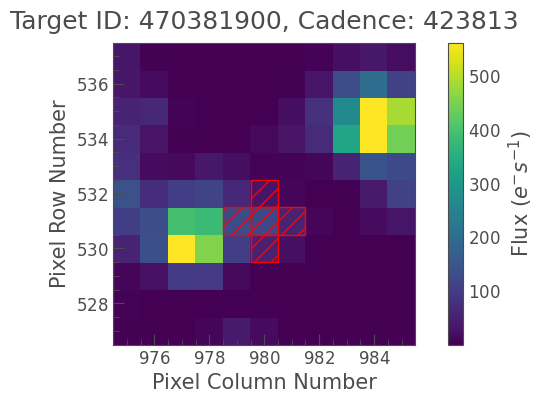

In [14]:
ax = tpf.plot(aperture_mask='pipeline')

In [18]:
pix_xy = np.nonzero(tpf.pipeline_mask)
# pixel locations of aperture
aper = np.c_[pix_xy[1] + tpf.column, pix_xy[0] + tpf.row]

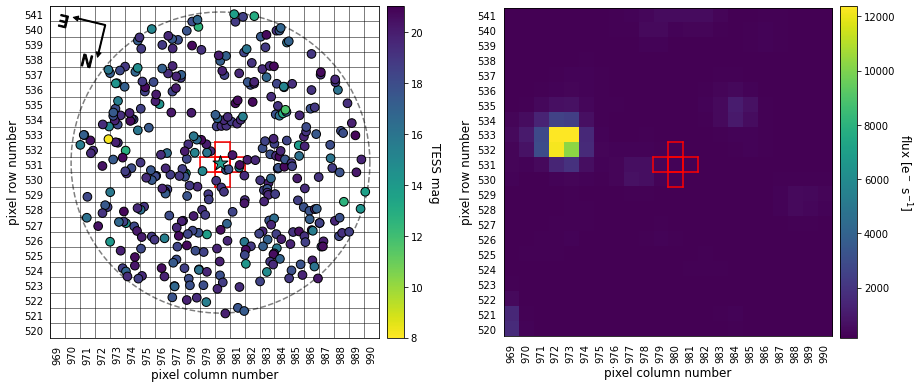

,ID,Tmag,Jmag,Hmag,Kmag,ra,dec,mass,rad,Teff,plx,sep (arcsec),PA (E of N)
0,470381900,13.9664,12.233,11.604,11.331,65.280563,48.819914,0.254505,0.280475,3181.00,15.376100,0.000,0.000
1,470381907,17.6880,15.466,15.593,15.289,65.276569,48.822072,1.220000,1.993890,6264.00,-0.185700,12.248,309.367
2,667421445,17.9456,NaN,NaN,NaN,65.275253,48.821595,0.970000,1.503530,5520.00,0.032989,13.967,295.689
3,667421446,20.2039,NaN,NaN,NaN,65.274735,48.816086,NaN,NaN,NaN,NaN,19.515,225.077
4,667421451,19.4761,NaN,NaN,NaN,65.287447,48.816698,NaN,NaN,NaN,1.671100,20.007,125.351
...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,470377924,13.6461,11.202,9.956,9.485,65.196110,48.816915,NaN,24.426100,3985.84,0.087711,200.481,266.945
359,667421554,20.1448,NaN,NaN,NaN,65.212027,48.852752,NaN,NaN,NaN,NaN,200.872,306.078
360,667421561,19.8483,NaN,NaN,NaN,65.259613,48.874147,NaN,NaN,NaN,-0.637102,201.448,345.744
361,667421638,19.3956,NaN,NaN,NaN,65.318859,48.869891,0.770000,0.584011,4789.00,1.520190,201.500,26.746


In [19]:
target.plot_field(sector=19, ap_pixels=aper)
 
target.stars

We can now determine which stars in the aperture are bright enough to produce the observed transit. The transit for this TOI has a depth of ~5000 ppm. We'll use the `.calc_depths(tdepth, all_ap_pixels)` method to do this. This method takes as arguments `tdepth` (the transit depth of the candidate) and `all_ap_pixels` (a numpy array of all apertures). After doing this, the `.stars` table includes the flux ratio contributed by each star in the aperture and the transit depth each star would have if it were the host of the signal.

https://exofop.ipac.caltech.edu/tess/target.php?id=470381900

In [22]:
tdepth = 11012.4838927907e-6 #± 1568.8007
P_orb = 2.50071474655903 #± .000511482

In [21]:
apertures = np.array([aper])
target.calc_depths(tdepth=tdepth, all_ap_pixels=apertures)

target.stars

,ID,Tmag,Jmag,Hmag,Kmag,ra,dec,mass,rad,Teff,plx,sep (arcsec),PA (E of N),fluxratio,tdepth
0,470381900,13.9664,12.233,11.604,11.331,65.280563,48.819914,0.254505,0.280475,3181.00,15.376100,0.000,0.000,5.256737e-01,0.020949
1,470381907,17.6880,15.466,15.593,15.289,65.276569,48.822072,1.220000,1.993890,6264.00,-0.185700,12.248,309.367,1.598312e-02,0.689007
2,667421445,17.9456,NaN,NaN,NaN,65.275253,48.821595,0.970000,1.503530,5520.00,0.032989,13.967,295.689,1.219011e-02,0.903395
3,667421446,20.2039,NaN,NaN,NaN,65.274735,48.816086,NaN,NaN,NaN,NaN,19.515,225.077,1.188886e-03,0.000000
4,667421451,19.4761,NaN,NaN,NaN,65.287447,48.816698,NaN,NaN,NaN,1.671100,20.007,125.351,1.845594e-03,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,470377924,13.6461,11.202,9.956,9.485,65.196110,48.816915,NaN,24.426100,3985.84,0.087711,200.481,266.945,9.679371e-29,0.000000
359,667421554,20.1448,NaN,NaN,NaN,65.212027,48.852752,NaN,NaN,NaN,NaN,200.872,306.078,1.417648e-33,0.000000
360,667421561,19.8483,NaN,NaN,NaN,65.259613,48.874147,NaN,NaN,NaN,-0.637102,201.448,345.744,3.667767e-32,0.000000
361,667421638,19.3956,NaN,NaN,NaN,65.318859,48.869891,0.770000,0.584011,4789.00,1.520190,201.500,26.746,2.563880e-32,0.000000


After doing this, we can calculate the probability of each scenario using the `.calc_prob(time, flux_0, flux_err_0, P_orb)` method, which requires as arguments `time` (times from phase-folded light curve in units of days from transit center), `flux_0` (normalized flux from phase-folded light curve), `flux_err_0` (flux error values of the target's phase-folded light curve), and `P_orb` (orbital period of the TOI in days).

If you have a lot of data points, I recommend binning your light curve down to ~100 to save time. Binning your data is poor practice when fitting light curves for a planet's parameters, but it doesn't yield significantly different results for our purposes. This should only take a few minutes.

In [25]:
# read in the light curve
lc = pd.read_csv("../vespa/tess_folded.csv", delim_whitespace=True, header=None)
time, flux, flux_err = lc[0].values, lc[1].values, lc[2].values

In [29]:
%%time
lc_binsize = (time.max()-time.min())/100
lc = TessLightCurve(time=time, flux=flux, flux_err=flux_err).bin(time_bin_size=lc_binsize)

target.calc_probs(time=lc.time.value, flux_0=lc.flux.value, flux_err_0=np.mean(lc.flux_err.value), P_orb=P_orb)

Calculating TP, EB, and EBx2P scenario probabilities for 470381900.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 470381900.
Calculating STP, SEB, and SEBx2P scenario probabilities for 470381900.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 470381900.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 470381900.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 470381907.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 667421445.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 470381897.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 470381901.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 470381912.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 470381899.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 667421452.
Calculating NTP, NEB, and NEB2xP scenario probabilities for 470381921.
CPU times: user 9min 46s, sys: 544 ms, total: 9min 47s
Wall time: 9min 58s


/home/jp/miniconda3/envs/tri/lib/python3.9/site-packages/triceratops/triceratops.py:1127: RuntimeWarning: invalid value encountered in double_scalars
  relative_probs[i] = (np.exp(lnZ[i])) / np.sum(np.exp(lnZ))


Now that that's done, let's check out a table of our results with the `.probs` attribute and calculate the false positive probability and nearby false positive probability using the `.FPP`  and `.NFPP` attributes. We expect a scatter of a few percent in our probabilities, so don't be alarmed if it's slightly different with each run. We can also plot the transit fits of each scenario using the `.plot_fits(time, flux_0, flux_err_0)` method.

In [30]:
df_results = target.probs
print("FPP =", np.round(target.FPP, 4))
print("NFPP =", np.round(target.NFPP, 4))
df_results

FPP = nan
NFPP = 0.0


,ID,scenario,M_s,R_s,P_orb,inc,ecc,w,R_p,M_EB,R_EB,prob
0,470381900,TP,0.254505,0.280475,2.500715,87.254911,1.862463e-01,229.879873,1.635354,0.000000,0.000000,NaN
1,470381900,EB,0.254505,0.280475,2.500715,85.682169,6.103464e-01,331.345082,0.000000,0.174494,0.206250,NaN
2,470381900,EBx2P,0.254505,0.280475,5.001429,87.684141,3.932121e-01,241.903120,0.000000,0.249594,0.274323,NaN
3,470381900,PTP,0.254505,0.280475,2.500715,87.829219,2.066755e-01,60.017510,3.904366,0.000000,0.000000,NaN
4,470381900,PEB,0.254505,0.280475,2.500715,88.428913,3.052473e-05,188.854296,0.000000,0.197188,0.227433,NaN
5,470381900,PEBx2P,0.254505,0.280475,5.001429,89.294840,1.462426e-01,321.201827,0.000000,0.252647,0.276998,NaN
6,470381900,STP,0.219847,0.247943,2.500715,85.480300,2.714687e-01,121.392864,3.673911,0.000000,0.000000,NaN
7,470381900,SEB,0.247093,0.272127,2.500715,86.889492,4.723335e-02,276.041539,0.000000,0.171585,0.203442,NaN
8,470381900,SEBx2P,0.226897,0.254248,5.001429,75.043801,9.102630e-01,112.986430,0.000000,0.220557,0.248579,NaN
9,470381900,DTP,0.254505,0.280475,2.500715,87.352164,1.253212e-02,201.093649,1.774484,0.000000,0.000000,NaN


* EB: No unresolved companion. Eclipsing binary with Porb around target star | 0.0341
* EBx2P: | 0.0454
* PTP: Unresolved bound companion. Transiting planet with Porb around primary star | 0.891
* SEB: Unresolved bound companion. Eclipsing binary with Porb around secondary star | 0.00216 (HEB)
* DTP: Unresolved background star. Transiting planet with Porb around target star | no counterpart in vespa

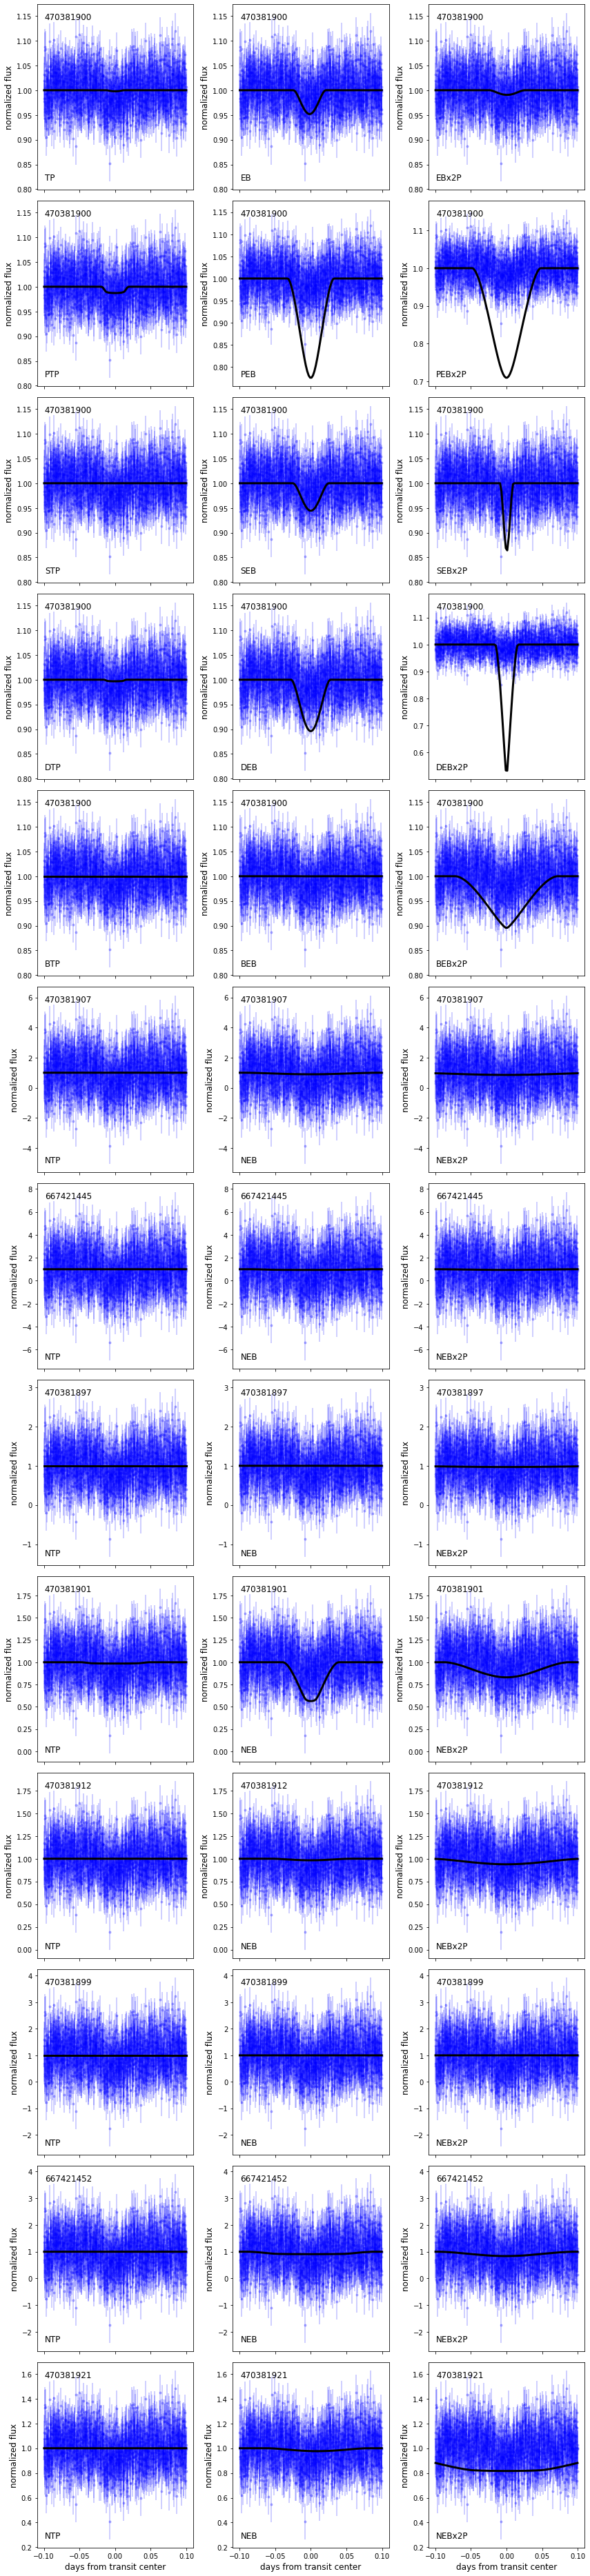

In [32]:
fig = target.plot_fits(time=time, flux_0=flux, flux_err_0=np.mean(flux_err))

If you plan to quote these results in a paper, you should run `.calc_probs()` several times and quote the mean and standard deviation of the FPP. This way, you can show that your result is not sensitive to the intrinsic scatter in the calculation.

We illustrate this below by calculating the FPP 20 times. We use the optional argument `parallel` to enable parallel light curve simulation, which makes the calculation ~5x faster. Enabling parallelization yields the same results as the non-parallel option, so you should feel free to set this argument to `True` at all times.

In [33]:
%%time

FPPs = np.zeros(20)
for i in range(20):
    target.calc_probs(time=lc.time.value, 
                      flux_0=lc.flux.value, 
                      flux_err_0=np.mean(lc.flux_err.value), 
                      P_orb=P_orb,
                      parallel=True,
                      verbose=0)
    FPPs[i] = target.FPP

meanFPP = np.round(np.mean(FPPs), 4)
stdvFPP = np.round(np.std(FPPs), 4)
print("FPP =", meanFPP, "+/-", stdvFPP)

/home/jp/miniconda3/envs/tri/lib/python3.9/site-packages/triceratops/triceratops.py:1127: RuntimeWarning: invalid value encountered in double_scalars
  relative_probs[i] = (np.exp(lnZ[i])) / np.sum(np.exp(lnZ))


FPP = nan +/- nan
CPU times: user 1h 5min 31s, sys: 59.3 s, total: 1h 6min 30s
Wall time: 22min 35s


## Example #2

Next, let's repeat this calculation while folding in follow up data. We'll see how including a contrast curve of the target star changes these results and further constrains the FPP. Note that the contrast curve file should be a csv with no headers, where the first column is the angular separation (in arcseconds) and the second column is the $\Delta$ mag.

In [36]:
contrastcurve_file = "../vespa/Gemini_r.cc"
cc = pd.read_csv(contrastcurve_file, header=None, delim_whitespace=True)
sep, dmag = cc[0].values, cc[1].values

In [45]:
cc.to_csv("../vespa/Gemini_r.csv", header=False, index=False)

In [47]:
contrastcurve_file = "../vespa/Gemini_r.csv"
cc = pd.read_csv(contrastcurve_file, header=None)
cc

,0,1
0,0.02,0.145
1,0.03,0.716
2,0.04,1.286
3,0.05,1.857
4,0.06,2.427
...,...,...
111,1.13,5.255
112,1.14,5.258
113,1.15,5.260
114,1.16,5.261


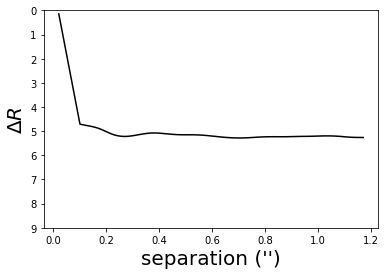

In [38]:
plt.plot(sep, dmag, 'k-');
plt.ylim(9,0);
plt.ylabel("$\\Delta R$", fontsize=20);
plt.xlabel("separation ('')", fontsize=20);

In [ ]:
%%time

FPPs = np.zeros(20)
for i in range(20):
    target.calc_probs(time=lc.time.value, 
                      flux_0=lc.flux.value, 
                      flux_err_0=np.mean(lc.flux_err.value), 
                      P_orb=P_orb,
                      contrast_curve_file=contrastcurve_file,
                      parallel=True,
                      verbose=0)
    FPPs[i] = target.FPP

meanFPP = np.round(np.mean(FPPs), 4)
stdvFPP = np.round(np.std(FPPs), 4)
print("FPP =", meanFPP, "+/-", stdvFPP)

/home/jp/miniconda3/envs/tri/lib/python3.9/site-packages/triceratops/triceratops.py:1127: RuntimeWarning: invalid value encountered in double_scalars
  relative_probs[i] = (np.exp(lnZ[i])) / np.sum(np.exp(lnZ))
